In [6]:
import numpy as np
import pandas as pd
import cvxpy as cp
import warnings
warnings.filterwarnings("ignore")

# Import scenario data
linecut = 96
scenario1 = pd.read_csv('data/Scenario1.csv').iloc[:linecut]
scenario2 = pd.read_csv('data/Scenario2.csv').iloc[:linecut]
scenario3 = pd.read_csv('data/Scenario3.csv').iloc[:linecut]
scenario4 = pd.read_csv('data/Scenario4.csv').iloc[:linecut]
scenario5 = pd.read_csv('data/Scenario5.csv').iloc[:linecut]
dt = 0.25 # 15-minute intervals
scenarios_data = [scenario1, scenario2, scenario3, scenario4, scenario5]

# Cost parameters
wind_cost_per_mw = 250
base_load_cost_per_mw = 360
peak_load_cost_per_mw = 200
load_following_option_fee = 50
load_following_exercise_fee = 18
service_fee = 5

max_wind_capacity = 20
max_generator_capacity = 10
solar_capacity = 1

# Decision variables (shared across scenarios)
wind_capacity = cp.Variable()
baseload_capacity = cp.Variable()
peak_capacity = cp.Variable()
load_following_capacity = cp.Variable()

# Constraints for shared variables
constraints = [
    wind_capacity >= 0,
    baseload_capacity >= 0,
    peak_capacity >= 0,
    load_following_capacity >= 0,
    wind_capacity <= max_wind_capacity,
    baseload_capacity + peak_capacity + load_following_capacity <= max_generator_capacity
]

# Fixed cost for all scenarios
fixed_cost = (
    wind_capacity * wind_cost_per_mw +
    baseload_capacity * base_load_cost_per_mw +
    peak_capacity * peak_load_cost_per_mw +
    load_following_capacity * load_following_option_fee
)

# Iterate over scenarios to define unique variables and costs
scenario_costs = []
i=0
real_time_cum = 0
for scenario in scenarios_data:
    time_steps = len(scenario)
    # Scenario-specific parameters as CVXPY constants
    demand_mw = cp.Parameter(time_steps, value=scenario["Demand [kW]"].values / 1000)
    real_time_price = cp.Parameter(time_steps, value=scenario["Real Time Price [$/MWh]"].values)
    wind_factor = cp.Parameter(time_steps, value=scenario["Wind Power Factor [p.u.]"].values)
    solar_factor = cp.Parameter(time_steps, value=scenario["Solar Power Factor [p.u.]"].values)

    # Renewable and base generation
    solar_gen = solar_capacity * solar_factor
    wind_gen = wind_capacity * wind_factor
    base_gen = baseload_capacity
    
    # Define peak gen using mask 1 for periods between 8 AM and 6 PM
    peak_active_mask = np.zeros(time_steps)
    peak_active_mask[8*4:18*4] = 1 
    peak_gen = peak_capacity * peak_active_mask

    # Calculate unmet demand
    unmet_demand = cp.pos(demand_mw - (solar_gen + wind_gen + base_gen + peak_gen))

    # Scenario-specific real-time variables
    load_follow_gen = cp.Variable(len(scenario), nonneg=True, name=f"load_follow_gen_{i}")
    spot_load = cp.Variable(len(scenario), nonneg=True, name=f"spot_load_{i}")

    # Real-time cost (load-following + spot market throughout day)
    real_time_cost = cp.sum(
        load_follow_gen * load_following_exercise_fee +  # Load-following cost
        spot_load * (real_time_price + service_fee)  # Spot market cost
    ) * 0.25

    # Real-time constraints for this scenario
    scenario_constraints = [
        load_follow_gen <= load_following_capacity,
        load_follow_gen + spot_load >= unmet_demand
    ]
    constraints.extend(scenario_constraints)

    # Total cost for this scenario
    real_time_cum += real_time_cost
    total_cost = fixed_cost + real_time_cost
    scenario_costs.append(total_cost)
    i+=1

# results
avg_cost = cp.sum(scenario_costs) / len(scenario_costs)
rt_avg = real_time_cum / len(scenario_costs) # avg cost to cover unmet demand

# standard deviation of cost across scenarios
cost_diff = cp.vstack([cost - avg_cost for cost in scenario_costs])
cost_sigma = cp.sqrt(cp.sum_squares(cost_diff) / len(scenario_costs))
cost_premium = 0 # PLACEHOLDER for cost premium expression

# Objective: Minimize the average cost across all scenarios
objective = cp.Minimize(avg_cost)
objective_CVaR = cp.Minimize(avg_cost+1.28*cost_sigma + cost_premium) #### CREATE OBJECTIVE BASED ON DESIRED RISK FUNCTION

# Define and solve the problem
problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.CBC, OptimalityTol=1e-6)

# Output results
if problem.status == cp.OPTIMAL:
    output = {
        "Minimum expected cost": round(problem.value, 4),
        "realtime cost avg": round(rt_avg.value, 4),
        "stdev of cost": round(cost_sigma.value.item(), 4),
        "Wind capacity (MW)": round(wind_capacity.value.item(), 4),
        "Baseload capacity (MW)": round(baseload_capacity.value.item(), 4),
        "Peak load capacity (MW)": round(peak_capacity.value.item(), 4),
        "Load following capacity (MW)": round(load_following_capacity.value.item(), 4)
    }
else:
    output = {"error": problem.status}

output

{'Minimum expected cost': 3311.2064,
 'realtime cost avg': 296.1522,
 'stdev of cost': 51.5343,
 'Wind capacity (MW)': 0.1089,
 'Baseload capacity (MW)': 7.7281,
 'Peak load capacity (MW)': 0.6142,
 'Load following capacity (MW)': 1.6578}

### CVar

In [18]:
import numpy as np
import pandas as pd
import cvxpy as cp
import warnings
warnings.filterwarnings("ignore")

# Import scenario data
linecut = 96
scenario1 = pd.read_csv('data/Scenario1.csv').iloc[:linecut]
scenario2 = pd.read_csv('data/Scenario2.csv').iloc[:linecut]
scenario3 = pd.read_csv('data/Scenario3.csv').iloc[:linecut]
scenario4 = pd.read_csv('data/Scenario4.csv').iloc[:linecut]
scenario5 = pd.read_csv('data/Scenario5.csv').iloc[:linecut]
dt = 0.25 # 15-minute intervals
scenarios_data = [scenario1, scenario2, scenario3, scenario4, scenario5]

# Cost parameters
wind_cost_per_mw = 250
base_load_cost_per_mw = 360
peak_load_cost_per_mw = 200
load_following_option_fee = 50
load_following_exercise_fee = 18
service_fee = 5

max_wind_capacity = 20
max_generator_capacity = 10
solar_capacity = 1

# Decision variables (shared across scenarios)
wind_capacity = cp.Variable()
baseload_capacity = cp.Variable()
peak_capacity = cp.Variable()
load_following_capacity = cp.Variable()

# Constraints for shared variables
constraints = [
    wind_capacity >= 0,
    baseload_capacity >= 0,
    peak_capacity >= 0,
    load_following_capacity >= 0,
    wind_capacity <= max_wind_capacity,
    baseload_capacity + peak_capacity + load_following_capacity <= max_generator_capacity
]

# Fixed cost for all scenarios
fixed_cost = (
    wind_capacity * wind_cost_per_mw +
    baseload_capacity * base_load_cost_per_mw +
    peak_capacity * peak_load_cost_per_mw +
    load_following_capacity * load_following_option_fee
)

def safe_round(value, decimals=4):
    """Safely round a value that might be None or a numpy array"""
    try:
        if hasattr(value, 'item'):
            return round(value.item(), decimals)
        return round(value, decimals)
    except (TypeError, AttributeError):
        return value

# Iterate over scenarios to define unique variables and costs
scenario_costs = []
i=0
real_time_cum = 0
for scenario in scenarios_data:
    time_steps = len(scenario)
    # Scenario-specific parameters as CVXPY constants
    demand_mw = cp.Parameter(time_steps, value=scenario["Demand [kW]"].values / 1000)
    real_time_price = cp.Parameter(time_steps, value=scenario["Real Time Price [$/MWh]"].values)
    wind_factor = cp.Parameter(time_steps, value=scenario["Wind Power Factor [p.u.]"].values)
    solar_factor = cp.Parameter(time_steps, value=scenario["Solar Power Factor [p.u.]"].values)

    # Renewable and base generation
    solar_gen = solar_capacity * solar_factor
    wind_gen = wind_capacity * wind_factor
    base_gen = baseload_capacity
    
    # Define peak gen using mask 1 for periods between 8 AM and 6 PM
    peak_active_mask = np.zeros(time_steps)
    peak_active_mask[8*4:18*4] = 1 
    peak_gen = peak_capacity * peak_active_mask

    # Calculate unmet demand
    unmet_demand = cp.pos(demand_mw - (solar_gen + wind_gen + base_gen + peak_gen))

    # Scenario-specific real-time variables
    load_follow_gen = cp.Variable(len(scenario), nonneg=True, name=f"load_follow_gen_{i}")
    spot_load = cp.Variable(len(scenario), nonneg=True, name=f"spot_load_{i}")

    # Real-time cost (load-following + spot market throughout day)
    real_time_cost = cp.sum(
        load_follow_gen * load_following_exercise_fee +  # Load-following cost
        spot_load * (real_time_price + service_fee)  # Spot market cost
    ) * 0.25

    # Real-time constraints for this scenario
    scenario_constraints = [
        load_follow_gen <= load_following_capacity,
        load_follow_gen + spot_load >= unmet_demand
    ]
    constraints.extend(scenario_constraints)

    # Calculate total cost with explicit scenario components
    variable_scenario_cost = real_time_cost  # Real-time costs vary by scenario
    fixed_scenario_cost = fixed_cost         # Fixed costs same across scenarios
    total_cost = fixed_scenario_cost + variable_scenario_cost
    real_time_cum += real_time_cost
    scenario_costs.append(total_cost)


# results
avg_cost = cp.sum(scenario_costs) / len(scenario_costs)
rt_avg = real_time_cum / len(scenario_costs) # avg cost to cover unmet demand

# standard deviation of cost across scenarios
cost_diff = cp.vstack([cost - avg_cost for cost in scenario_costs])
cost_sigma = cp.sqrt(cp.sum_squares(cost_diff) / len(scenario_costs))

#cost_premium = 0 # PLACEHOLDER for cost premium expression

# CVaR implementation 
alpha = cp.Variable()  # VaR threshold mean+1.28*sigma
M = cp.Variable(len(scenarios_data), nonneg=True)  # Excess losses for each scenario
beta = 0.8  # CVaR confidence level (focusing on worst 20% of scenarios)

# Add CVaR constraints with explicit scenario consideration
scenario_prob = 1.0/len(scenarios_data)  # Equal probability for each scenario
for s in range(len(scenarios_data)):
    constraints.extend([
        M[s] >= scenario_costs[s] - alpha,  # Excess above threshold
        M[s] >= 0  # Non-negativity still explicit for clarity
    ])

# Calculate CVaR objective with proper weighting
cost_premium = alpha + (1/(len(scenarios_data)*(1-beta))) * cp.sum(M)


# Define two separate objectives for our two optimization problems
objective_expected = cp.Minimize(avg_cost)  # Original expected value minimization
objective_CVaR = cp.Minimize(cost_premium)  # CVaR minimization

# Define and solve both problems
problem_expected = cp.Problem(objective_expected, constraints)
problem_CVaR = cp.Problem(objective_CVaR, constraints)

# Solve expected value problem
print("Solving expected value minimization...")
problem_expected.solve(solver=cp.CBC, OptimalityTol=1e-6, FeasibilityTol=1e-6)

# Solve CVaR problem
print("\nSolving CVaR minimization...")
problem_CVaR.solve(solver=cp.CBC, OptimalityTol=1e-6, FeasibilityTol=1e-6)

# Output results with both solutions
if problem_expected.status == cp.OPTIMAL and problem_CVaR.status == cp.OPTIMAL:
    output = {
        "Expected Value Results": {
            "Minimum expected cost": safe_round(problem_expected.value),
            "realtime cost avg": safe_round(rt_avg.value),
            "stdev of cost": safe_round(cost_sigma.value),
            "Wind capacity (MW)": safe_round(wind_capacity.value),
            "Baseload capacity (MW)": safe_round(baseload_capacity.value),
            "Peak load capacity (MW)": safe_round(peak_capacity.value),
            "Load following capacity (MW)": safe_round(load_following_capacity.value)
        },
        "CVaR Results": {
            "CVaR value": safe_round(problem_CVaR.value),
            "VaR threshold": safe_round(alpha.value),
            "Wind capacity (MW)": safe_round(wind_capacity.value),
            "Baseload capacity (MW)": safe_round(baseload_capacity.value),
            "Peak load capacity (MW)": safe_round(peak_capacity.value),
            "Load following capacity (MW)": safe_round(load_following_capacity.value)
        }
    }
else:
    output = {
        "Expected Value Status": problem_expected.status,
        "CVaR Status": problem_CVaR.status
    }

output

Solving expected value minimization...

Solving CVaR minimization...


{'Expected Value Results': {'Minimum expected cost': 3311.2064,
  'realtime cost avg': 306.383,
  'stdev of cost': 0.0,
  'Wind capacity (MW)': 0.2145,
  'Baseload capacity (MW)': 7.7902,
  'Peak load capacity (MW)': 0.6351,
  'Load following capacity (MW)': 1.5747},
 'CVaR Results': {'CVaR value': 3370.2448,
  'VaR threshold': 3370.2448,
  'Wind capacity (MW)': 0.2145,
  'Baseload capacity (MW)': 7.7902,
  'Peak load capacity (MW)': 0.6351,
  'Load following capacity (MW)': 1.5747}}

#### Renewable Study
Now, lets investigate the feasibility of using extended solar with onsite storage (assuming battery) of proportionate size. 
Assuming storage has no degradation over a 10year lifespan with only upfront cost of 25000 + 1000/MW... ie set costs to 10yr sum

In [2]:
# Given Cost parameters
wind_cost_per_mw = 250
base_load_cost_per_mw = 360
peak_load_cost_per_mw = 200
load_following_option_fee = 50
load_following_exercise_fee = 18
service_fee = 5

# CO2 Cost Premium
co2_cost_per_mw = 1.2 # mW premium needs work


# Solar cost parameters NEEDS WORK
solar_fixed_cost = 0  # Upfront cost
solar_cost_per_mw = 100000  # Cost per MW of storage capacity
solar_lifespan_years = 20  # Lifespan over which to amortize the storage cost
max_solar_capacity = 10 # Maximum solar capacity, limited by surface area
solar_capacity = cp.Variable(nonneg=True)

# Storage cost parameters NEEDS WORK
storage_fixed_cost = 0  # Upfront cost
storage_cost_per_mwh = 25000  # Cost per MWh of storage capacity
storage_lifespan_years = 15  # Lifespan over which to amortize the storage cost
max_storage_capacity = 10  # Maximum storage capacity, limited by space
storage_capacity = cp.Variable(nonneg=True)
storage_cd_rate = cp.Parameter(nonneg=True)  # Charge/discharge rate NEEDS WORK
storage_cd_rate = 0.1*storage_capacity

max_wind_capacity = 20
max_generator_capacity = 10

# Decision variables (shared across scenarios)
wind_capacity = cp.Variable(nonneg=True)
baseload_capacity = cp.Variable(nonneg=True)
peak_capacity = cp.Variable(nonneg=True)
load_following_capacity = cp.Variable(nonneg=True)

# Constraints for shared variables
constraints = [
    wind_capacity >= 0,
    baseload_capacity >= 0,
    peak_capacity >= 0,
    load_following_capacity >= 0,
    storage_capacity >= 0,
    solar_capacity >= 0,
    solar_capacity <= max_solar_capacity,
    storage_capacity <= max_storage_capacity,
    wind_capacity <= max_wind_capacity,
    baseload_capacity + peak_capacity + load_following_capacity <= max_generator_capacity
]

# Fixed cost for all scenarios (annualized storage cost over its lifespan)
storage_cost = (storage_fixed_cost + storage_cost_per_mwh * storage_capacity) / (storage_lifespan_years*365)
solar_cost = (solar_fixed_cost + solar_cost_per_mw * solar_capacity) / (solar_lifespan_years*365)

fixed_cost = (
    wind_capacity * wind_cost_per_mw +
    (baseload_capacity * base_load_cost_per_mw +
    peak_capacity * peak_load_cost_per_mw +
    load_following_capacity * load_following_option_fee)*co2_cost_per_mw +
    storage_cost
)

# Iterate over scenarios to define unique variables and costs
scenario_costs = []
real_time_cum = 0
i = 0
for scenario in scenarios_data:
    time_steps = len(scenario)
    # Scenario-specific parameters as CVXPY constants
    demand_mw = cp.Parameter(time_steps, value=scenario["Demand [kW]"].values / 1000)
    real_time_price = cp.Parameter(time_steps, value=scenario["Real Time Price [$/MWh]"].values)
    wind_factor = cp.Parameter(time_steps, value=scenario["Wind Power Factor [p.u.]"].values)
    solar_factor = cp.Parameter(time_steps, value=scenario["Solar Power Factor [p.u.]"].values)

    # Renewable and base generation
    solar_gen = solar_capacity * solar_factor
    wind_gen = wind_capacity * wind_factor
    base_gen = baseload_capacity

    # Define peak gen using mask 1 for periods between 8 AM and 6 PM
    peak_active_mask = np.zeros(time_steps)
    peak_active_mask[8*4:18*4] = 1  # Assuming data is in 15-minute intervals
    peak_gen = peak_capacity * peak_active_mask

    # Scenario-specific variables for storage operation
    storage_charge = cp.Variable(time_steps, nonneg=True, name=f"storage_charge_{i}")
    storage_discharge = cp.Variable(time_steps, nonneg=True, name=f"storage_discharge_{i}")
    storage_soc = cp.Variable(time_steps, name=f"storage_soc_{i}")


    # Storage operational constraints
    for t in range(time_steps): # for each 15min time step
        # Storage state of charge dynamics
        if t == 0:
            # Initial storage state of charge (assuming starting at half-charge)
            constraints += [storage_soc[0] == storage_capacity / 2]
        else:
            constraints += [
                storage_soc[t] == storage_soc[t-1] + (storage_charge[t] - storage_discharge[t])*dt
            ]
        # Storage capacity constraints
        constraints += [
            storage_soc[t] >= 0,
            storage_soc[t] <= storage_capacity,
            storage_charge[t] <= storage_cd_rate,
            storage_discharge[t] <= storage_cd_rate
        ]

    # Scenario-specific real-time variables
    load_follow_gen = cp.Variable(time_steps, nonneg=True, name=f"load_follow_gen_{i}")
    spot_load = cp.Variable(time_steps, nonneg=True, name=f"spot_load_{i}")

    # Energy balance constraints
    for t in range(time_steps):
        # Total generation and demand balance
        constraints += [
            solar_gen[t] + wind_gen[t] + base_gen + peak_gen[t] + storage_discharge[t] + load_follow_gen[t] + spot_load[t]
            >= demand_mw[t] + storage_charge[t]
        ]

    # Real-time constraints for load following and spot market
    constraints += [
        load_follow_gen <= load_following_capacity
    ]

    # Real-time cost (load-following + spot market throughout the day)
    real_time_cost = cp.sum(
        load_follow_gen * load_following_exercise_fee +
        spot_load * (real_time_price + service_fee)
    ) * 0.25  # Assuming 15-minute intervals

    # Total cost for this scenario
    total_cost = fixed_cost + real_time_cost
    scenario_costs.append(total_cost)
    real_time_cum += real_time_cost
    i += 1

# Results
avg_cost = cp.sum(scenario_costs) / len(scenario_costs)
rt_avg = real_time_cum / len(scenario_costs)  # Average cost to cover unmet demand

# Standard deviation of cost across scenarios
cost_diff = cp.vstack([cost - avg_cost for cost in scenario_costs])
cost_sigma = cp.sqrt(cp.sum_squares(cost_diff) / len(scenario_costs))
cost_premium = 0  # Placeholder for cost premium expression

# Objective: Minimize the average cost across all scenarios
objective = cp.Minimize(avg_cost)
# objective_CVaR = cp.Minimize(avg_cost + 1.28 * cost_sigma + cost_premium)  # Risk function if needed

# Define and solve the problem
problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.GUROBI, OptimalityTol=1e-6)

# Output results
if problem.status == cp.OPTIMAL:
    output = {
        "Minimum expected cost": round(problem.value, 4),
        "Real-time cost average": round(rt_avg.value, 4),
        "Standard deviation of cost": round(cost_sigma.value.item(), 4),
        "Wind capacity (MW)": round(wind_capacity.value.item(), 4),
        "Baseload capacity (MW)": round(baseload_capacity.value.item(), 4),
        "Peak load capacity (MW)": round(peak_capacity.value.item(), 4),
        "Load following capacity (MW)": round(load_following_capacity.value.item(), 4),
        "Solar capacity (MW)": round(solar_capacity.value.item(), 4),
        "Storage capacity (MW)": round(storage_capacity.value.item(), 4)
    }
else:
    output = {"error": problem.status}

output

{'Minimum expected cost': 3456.6598,
 'Real-time cost average': 198.5996,
 'Standard deviation of cost': 112.5417,
 'Wind capacity (MW)': 0.0,
 'Baseload capacity (MW)': 7.1686,
 'Peak load capacity (MW)': 0.0,
 'Load following capacity (MW)': 1.9258,
 'Solar capacity (MW)': 10.0,
 'Storage capacity (MW)': 10.0}

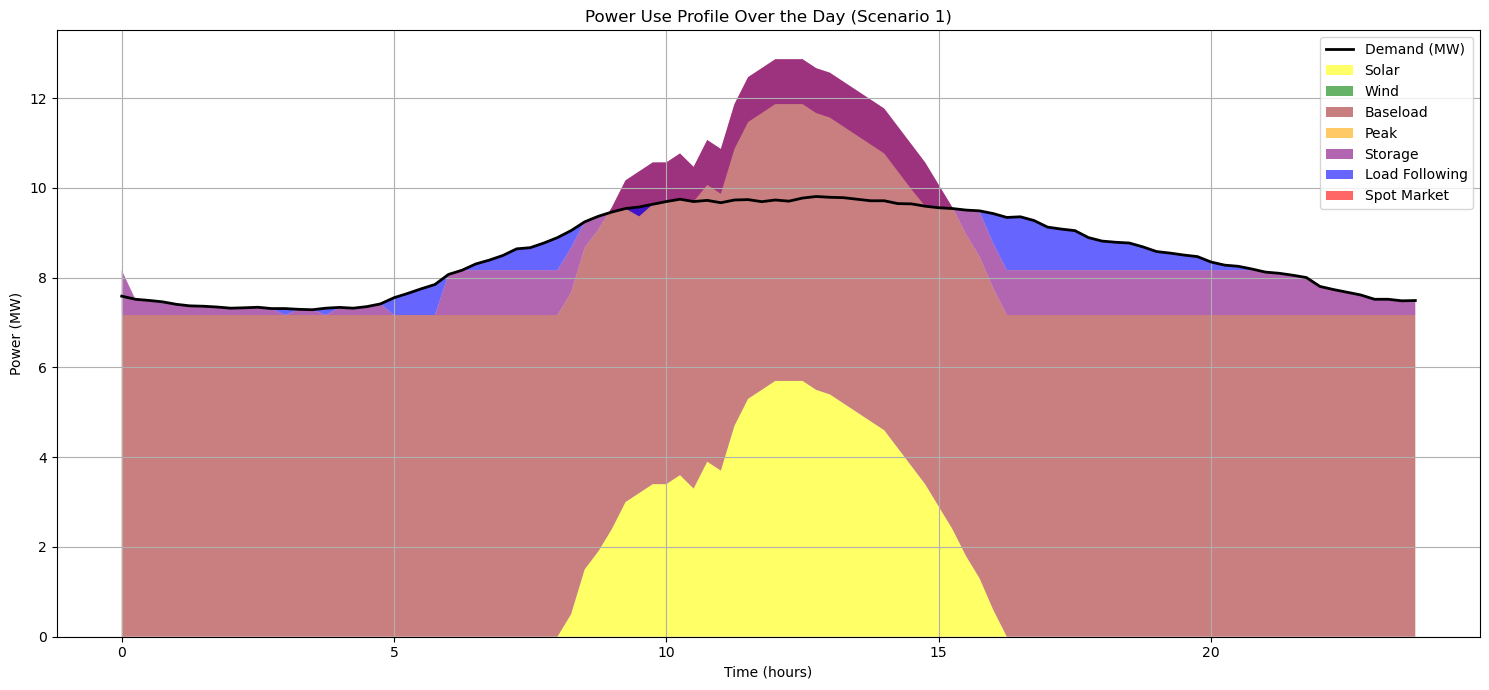

In [3]:
import matplotlib.pyplot as plt
# Plotting the power use profile for the first scenario
# Extract the values after optimization
sc_choice = 4 # Choose the scenario to plot
time_steps = len(scenarios_data[sc_choice])
t = np.arange(time_steps) * dt  # Time in hours

# Retrieve the optimized generation values
solar_gen_val = solar_capacity.value * scenarios_data[sc_choice]["Solar Power Factor [p.u.]"].values
wind_gen_val = wind_capacity.value * scenarios_data[sc_choice]["Wind Power Factor [p.u.]"].values
base_gen_val = baseload_capacity.value * np.ones(time_steps)
peak_gen_val = peak_capacity.value * peak_active_mask

storage_discharge_val = storage_discharge.value
storage_charge_val = storage_charge.value

load_follow_gen_val = load_follow_gen.value
spot_load_val = spot_load.value

# Calculate total generation at each time step
total_generation = (
    solar_gen_val + wind_gen_val + base_gen_val + peak_gen_val + storage_discharge_val + load_follow_gen_val + spot_load_val
    - storage_charge_val  # Subtract storage charge as it consumes power
)

demand_mw_val = scenarios_data[sc_choice]["Demand [kW]"].values / 1000

# Plotting
plt.figure(figsize=(15, 7))

plt.plot(t, demand_mw_val, label='Demand (MW)', color='black', linewidth=2)

plt.stackplot(t,
              solar_gen_val, wind_gen_val, base_gen_val, peak_gen_val,
              storage_discharge_val - storage_charge_val,  # Net storage contribution
              load_follow_gen_val, spot_load_val,
              labels=['Solar', 'Wind', 'Baseload', 'Peak', 'Storage', 'Load Following', 'Spot Market'],
              colors=['yellow', 'green', 'brown', 'orange', 'purple', 'blue', 'red'],
              alpha=0.6)

plt.xlabel('Time (hours)')
plt.ylabel('Power (MW)')
plt.title('Power Use Profile Over the Day (Scenario 1)')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()